In [2]:
import pandas as pd
import matplotlib.pyplot as plt


df1 = pd.read_csv('HoC-GE2024-results-by-candidate.csv')
print(df1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4515 entries, 0 to 4514
Data columns (total 22 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   ONS ID                                 4515 non-null   object 
 1   ONS region ID                          4507 non-null   object 
 2   Constituency name                      4515 non-null   object 
 3   County name                            0 non-null      float64
 4   Region name                            4515 non-null   object 
 5   Country name                           4515 non-null   object 
 6   Constituency type                      4515 non-null   object 
 7   Party name                             4515 non-null   object 
 8   Party abbreviation                     4515 non-null   object 
 9   Electoral Commission party ID          4055 non-null   object 
 10  MNIS party ID                          4515 non-null   int64  
 11  Elec

In [3]:
df2 = pd.read_csv('HoC-GE2024-results-by-constituency.csv')

print(df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650 entries, 0 to 649
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ONS ID                 650 non-null    object 
 1   ONS region ID          650 non-null    object 
 2   Constituency name      650 non-null    object 
 3   County name            0 non-null      float64
 4   Region name            650 non-null    object 
 5   Country name           650 non-null    object 
 6   Constituency type      650 non-null    object 
 7   Declaration time       0 non-null      float64
 8   Member first name      650 non-null    object 
 9   Member surname         650 non-null    object 
 10  Member gender          650 non-null    object 
 11  Result                 650 non-null    object 
 12  First party            650 non-null    object 
 13  Second party           650 non-null    object 
 14  Electorate             650 non-null    int64  
 15  Valid 

Preprocessing: if share change is marked as NA, then vote share will be used as the change.

For example: A party participates for first time in the constituency, so the change is recorded as NA. The party has managed to get 15% of the votes. As a result, the change will be recorded as 15%.

In [ ]:
df1.Change.fillna(df1.Share, inplace=True)

<ipython-input-52-1e8c6aab768c>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1.Change.fillna(df1.Share, inplace=True)


Firstly, lets try to get the general election result - basically, the most important info, critical in any election coverage, or visible at any wiki election page.

In [ ]:
result_by_party = df1.groupby(['Party abbreviation'])['Votes'].sum().reset_index()
result_by_party['Vote percentage'] = result_by_party['Votes'] / result_by_party['Votes'].sum()

party_seats = df2.groupby('First party')['ONS ID'].count().reset_index().rename(columns={'First party': 'Party abbreviation', 'ONS ID': 'Seats'})
result_by_party = pd.merge(result_by_party, party_seats, how='left', on='Party abbreviation')
result_by_party.fillna({'Seats': 0}, inplace=True)
result_by_party['Seat percentage'] = result_by_party['Seats'] / result_by_party['Seats'].sum()

result_by_party=result_by_party.sort_values(by=['Seats', 'Votes'], ascending=False)
print(result_by_party)


   Party abbreviation    Votes  Vote percentage  Seats  Seat percentage
45                Lab  9708716         0.337007  411.0         0.632308
24                Con  6828925         0.237044  121.0         0.186154
42                 LD  3519143         0.122156   72.0         0.110769
75                SNP   724758         0.025158    9.0         0.013846
69                 SF   210891         0.007320    7.0         0.010769
..                ...      ...              ...    ...              ...
14                 CF      131         0.000005    0.0         0.000000
44               LPUK      113         0.000004    0.0         0.000000
60                PSY       99         0.000003    0.0         0.000000
18                 CP       91         0.000003    0.0         0.000000
35                IDD       45         0.000002    0.0         0.000000

[97 rows x 5 columns]


Once we have the general table, we can do something more useful - for example, comparing how well votes translate into seats.

Result shows that it doesn't translate that well. For example, Labour party has only received 33.7% of the popular vote, but got 63% of the seats. Why is this the case?

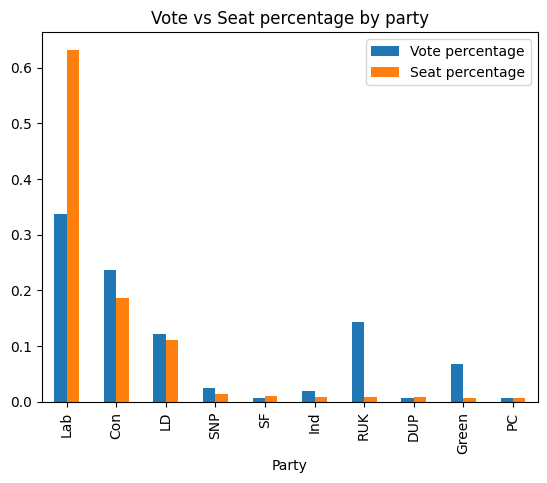

In [ ]:
result_by_party[['Party abbreviation', 'Vote percentage', 'Seat percentage']][:10].plot(kind='bar', title='Vote vs Seat percentage by party', x='Party abbreviation', xlabel='Party');

To investigate the reason for this discrepancy deeper, lets take a look into one of constituencies. In UK, MP is elected if they get the most votes in constituency - no second round is ever organised. Lets take one, which had the smallest majority for the winning party.

We can see that only 15 votes have separated the two big parties. However, we can also observe that both major parties have only got 76% of the vote, and really only these two seemed to have a chance to win, which means that the rest of those votes were wasted.

Since Reform UK and Conservative Party has a relatively similar right-wing voter, it makes one wonder, that if, for example, Reform UK candidate did not run, perhaps their voters would have voted for the conservatives, and that would have been enough for the victory. In this sense, participation of Reform might have spoiled the election for the conservatives.

Alternatively, it is also possible that left-wing Greens, Workers Party and perhaps Liberal Democrats made it way too close for comfort for the Labour party.

In general, all of this is known as spoiler effect, and it is a known fact that this electoral system leads to two-party system, as running as a smaller party tends to harm one of bigger ones.

In [ ]:
constituency_with_smallest_majority = df2['Constituency name'][df2['Majority']==df2['Majority'].min()].values[0]
smallest_constituency_data = df1[['Party name', 'Votes', 'Share', 'Change']][df1['Constituency name'] == constituency_with_smallest_majority].sort_values(by=['Votes'], ascending=False)
print(smallest_constituency_data)

                    Party name  Votes     Share    Change
1950                    Labour  15855  0.384308 -0.024483
1949              Conservative  15840  0.383944 -0.105144
1948                 Reform UK   3038  0.073638  0.073638
1947                     Green   2667  0.064645  0.048261
1946          Liberal Democrat   1966  0.047654 -0.038083
1945  Workers Party of Britain   1518  0.036795  0.036795
1944                 Rejoin EU    233  0.005648  0.005648
1943   Social Democratic Party    139  0.003369  0.003369


Now lets try to get the boxplot of how well each party did in each constituency.

As we can expect, two biggest parties, Labour and Conservative, have both done pretty well, though there is a big range to their results.

Additionally, we can see that Greens, Independents and Liberal Democrats have a lot outliers. This is causesd by the fact that these parties tend to compete throughout the country, in all 650 seats, but generally do very poorly, so outliers are the seats they actually won.

SNP, on the other hand, seems to have a few outliers that are below the IQR. These seem to be more genuine outliers, since this party tends to do really well In Scotland, and these are the seats that they did particularly bad in. This could prove an interesting study.



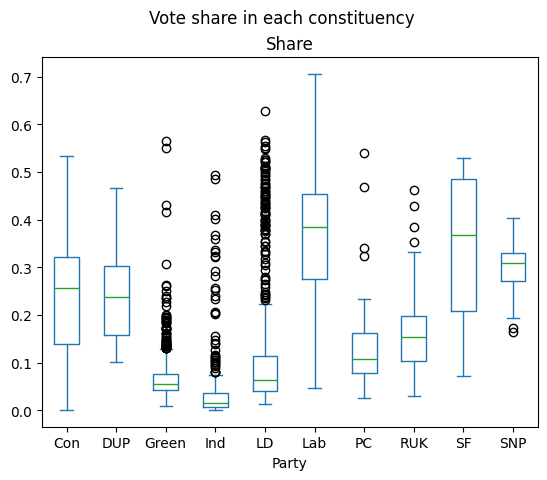

In [ ]:
party_names = list(result_by_party['Party abbreviation'].values)
shares_by_party_constituency = df1[df1['Party abbreviation'].isin(party_names[:10])].groupby(['Constituency name', 'Party abbreviation'])['Share'].sum().reset_index().sort_values('Party abbreviation', key=lambda x: [party_names.index(i) for i in x], ascending=True)
shares_by_party_constituency.plot(kind='box', by='Party abbreviation', title='Vote share in each constituency', column='Share', xlabel='Party');

Lets also get a boxplot of how vote share has changed for each party in constituency.

Conservatives seemed to have had poor results constantly, with no clear outliers. Labour did not improve much on their vote share, and they had some terrible swings against them in some constituencies. Reform UK did quite well, and in some places they had really good performance.

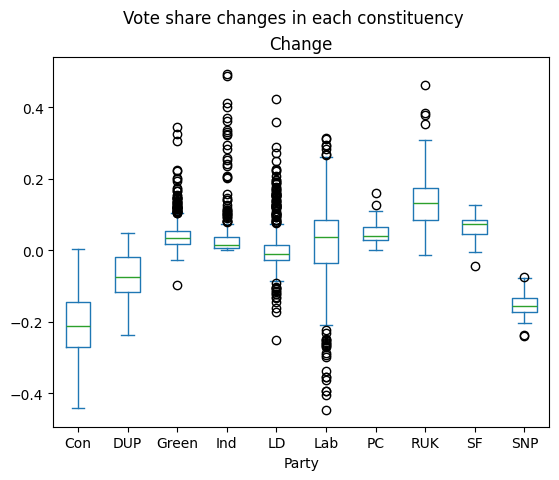

In [ ]:
changes_by_party_constituency = df1[df1['Party abbreviation'].isin(party_names[:10])].groupby(['Constituency name', 'Party abbreviation'])['Change'].sum().reset_index().sort_values('Party abbreviation', key=lambda x: [party_names.index(i) for i in x], ascending=True)
changes_by_party_constituency.plot(kind='box', by='Party abbreviation', title='Vote share changes in each constituency', column='Change', xlabel='Party');

Next we will try to get correlation matrix of results of each party.

Results, in some ways, are understandable, and in other ways are surprising.
- Labour and Conservatives have negative correlation (unsurprising - they are the main competitors)
- Labour and Liberals have very negative correlation (unsurprising - they have similar electorate, and if they both exist, they hurt each other)
- Labour and Greens have a positive correlation (unsurprising - greens have a bigger chance to win over labour voters)
- Conservative and Reform have a negative correlation (surprising - you would expect that only one of these party to exist, since they hurt each other. Perhaps this is because Reform is a new party, so it's not yet set in stone)

In [ ]:
shares_by_party = df2.copy()
list_of_party_columns = ['Con', 'Lab', 'LD', 'RUK', 'Green', 'SNP', 'PC', 'DUP', 'SF', 'SDLP', 'UUP', 'APNI', 'All other candidates', 'Of which other winner']
for party in list_of_party_columns:
    shares_by_party[party] = shares_by_party[party]/shares_by_party['Valid votes']

print(shares_by_party[['Con', 'Lab', 'LD', 'RUK', 'Green']].corr())

            Con       Lab        LD       RUK     Green
Con    1.000000 -0.329508  0.231433  0.296043 -0.227589
Lab   -0.329508  1.000000 -0.608905  0.115493  0.311863
LD     0.231433 -0.608905  1.000000 -0.186405 -0.148513
RUK    0.296043  0.115493 -0.186405  1.000000 -0.196965
Green -0.227589  0.311863 -0.148513 -0.196965  1.000000


To dig deeper into the surprising correlation result, I have decided to take only those constituencies, which labour has managed to take from the Conservative party. There are 182/650 such constiutencies.

It would seem that in these instances, there has been negative correlation between the Conservative and Reform parties. This would imply that in these vulnerable seats right-wing vote has actually been pretty consolidated.

This would disprove the common conception, that right-wing split has been the reason for the Conservative defeat, but obviously a deeper study is required.

In [ ]:
print(shares_by_party[['Con', 'Lab', 'LD', 'RUK', 'Green']][shares_by_party['Result']=='Lab gain from Con'].corr())

            Con       Lab        LD       RUK     Green
Con    1.000000 -0.333757  0.021004 -0.463720 -0.034334
Lab   -0.333757  1.000000 -0.303859 -0.152320  0.006823
LD     0.021004 -0.303859  1.000000 -0.393862 -0.016057
RUK   -0.463720 -0.152320 -0.393862  1.000000 -0.210723
Green -0.034334  0.006823 -0.016057 -0.210723  1.000000
